In [2]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
DATA_ROOT = Path('../../data')
IMAGE_1_NAME = Path('tsukuba_l.png')
IMAGE_2_NAME = Path('tsukuba_r.png')

In [45]:
def get_derivatives(img1 : np.ndarray, img2: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    # get the derivatives
    Ix = cv2.filter2D(img1, -1, np.array([[-1, 1], [-1, 1]]))
    Iy = cv2.filter2D(img1, -1, np.array([[-1, -1], [1, 1]]))
    It = cv2.filter2D(img1, -1, np.array([[-1, -1], [-1, -1]]) * 0.25) + cv2.filter2D(img2, -1, np.array([[1, 1], [1, 1]]) * 0.25)
    return Ix, Iy, It

def optical_flow(img1 : np.ndarray, img2: np.ndarray, window_half: int = 2, threshold: float = 0.01) -> tuple[np.ndarray, np.ndarray]:
    # get the derivatives
    Ix, Iy, It = get_derivatives(img1, img2)
    u = np.zeros_like(img1)
    v = np.zeros_like(img1)
    for i in range(window_half, img1.shape[0] - window_half):
        for j in range(window_half, img1.shape[1] - window_half):
            # get the window
            Ix_window = Ix[i - window_half:i + window_half + 1, j - window_half:j + window_half + 1].flatten()
            Iy_window = Iy[i - window_half:i + window_half + 1, j - window_half:j + window_half + 1].flatten()
            It_window = It[i - window_half:i + window_half + 1, j - window_half:j + window_half + 1].flatten()
            # solve the least squares problem
            b = np.reshape(It_window, (It_window.shape[0],1)) 
            A = np.vstack((Ix_window, Iy_window)).T 
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= threshold:
                nu = np.matmul(np.linalg.pinv(A), b)
                u[i,j]=nu[0][0]
                v[i,j]=nu[1][0]
    return u, v

def plot_optical_flow(img1 : np.ndarray, img2: np.ndarray, u: np.ndarray, v: np.ndarray, step: int = 10):
    # plot the image
    plt.imshow(img1, cmap='gray')
    # get the grid
    x, y = np.meshgrid(np.arange(0, img1.shape[1], step), np.arange(0, img1.shape[0], step))
    # plot the flow
    plt.quiver(x, y, u[::step, ::step], v[::step, ::step], color='r')
    plt.show()

In [46]:
#load images
img1 = cv2.imread(str(DATA_ROOT/IMAGE_1_NAME))
img2 = cv2.imread(str(DATA_ROOT/IMAGE_2_NAME))

#convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#get optical flow
# flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
u, v = optical_flow(img1_gray, img2_gray, 15, 1e-1)



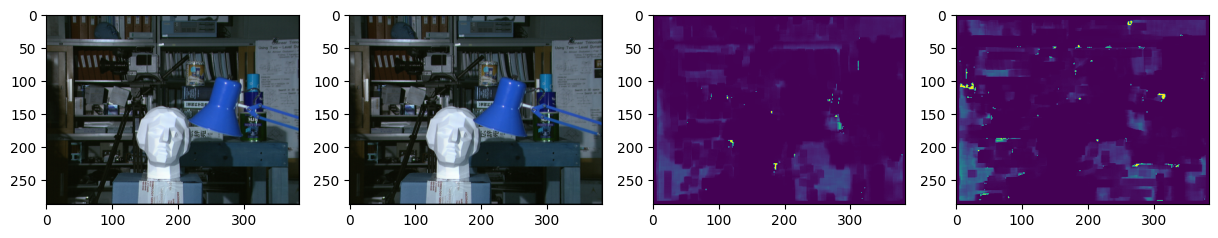

In [6]:
#plot images and u, v
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(u)
ax[3].imshow(v)
plt.show()

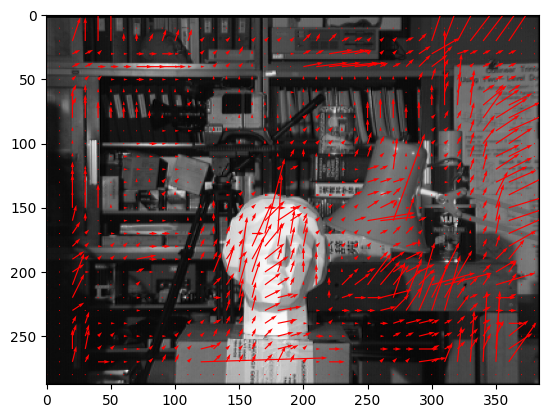

In [47]:
plot_optical_flow(img1_gray,img2_gray, u, v, 10)

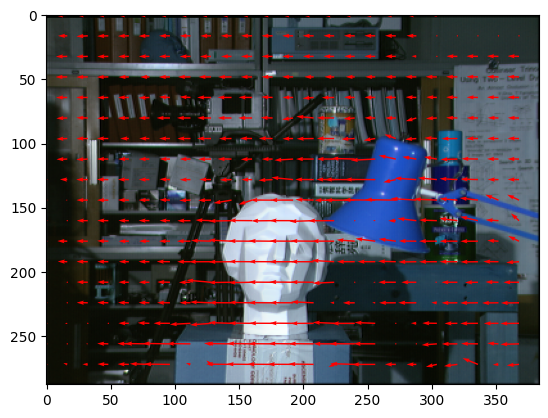

In [15]:
flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

#plot optical flow vectors
# plt.imshow(img1)
plot_optical_flow(img1=img1, img2=img2, u=flow[...,0], v=flow[...,1], step=16)


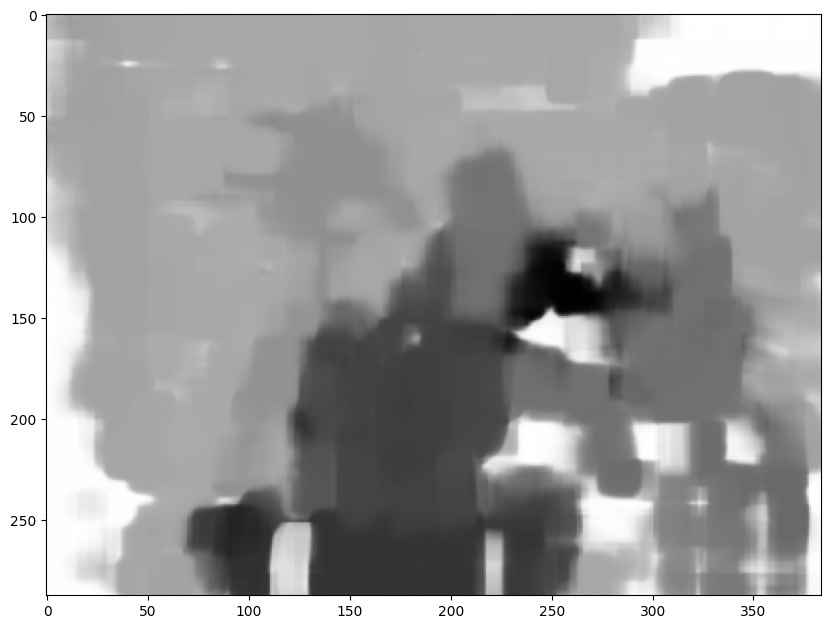

In [49]:
# plot dense magnitudes

plt.figure(figsize=(10, 10))
plt.imshow(flow[...,0], cmap='gray')
plt.show()